In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy as sc
from scipy import stats
import statsmodels.formula.api as smf

import os
import sys
sys.path.append('../..')

import cellspec as spc

In [2]:
# adata = spc.pp.load_vcf('../data/bulk_worm/worm_N2_Pole1_joint.vcf.gz')
# adata

In [3]:
# adata.write_h5ad('../results/worm_mut_accumulation/bulk_worm_raw.h5ad')

In [4]:
adata = ad.io.read_h5ad('../results/worm_mut_accumulation/bulk_worm_raw.h5ad')

In [5]:
adata.obs_names = adata.obs.index.map(os.path.basename).str[:-4]

In [6]:
obs = {
    'N2_P2G1':['WT','P2',1],
    'N2_P2G2':['WT','P2',2],
    'N2_P2G3':['WT','P2',3],
    'N2_P3G1':['WT','P3',1],
    'N2_P3G2':['WT','P3',2],
    'N2_P3G3':['WT','P3',3],
    'N3_P4G1':['WT','P4',1],
    'N3_P4G2':['WT','P4',2],
    'N3_P4G3':['WT','P4',3],
    'Pole-1_P1G1':['P270R','P1',1],
    'Pole-1_P1G2':['P270R','P1',2],
    'Pole-1_P1G3':['P270R','P1',3],
    'Pole-1_P2G1':['P270R','P2',1],
    'Pole-1_P2G2':['P270R','P2',2],
    'Pole-1_P2G3':['P270R','P2',3]
}
adata.obs = pd.DataFrame.from_dict(obs, orient='index', columns=['Mutation','Replicate','Generation'])
# adata.obs

In [7]:
# Load sequencing run coverage stats
adata.obs[['mean_coverage', 'callable_Mb_10x']] = pd.read_csv('../results/worm_mut_accumulation/coverage_summary.tsv', sep='\t', index_col='sample')[['mean_coverage', 'callable_Mb_10x']]


In [8]:
## Filter out non snps
spc.pp.filter_to_snps(adata, inplace=True)

In [9]:
## Filter out sites without sufficient coverage in all samples
spc.pp.filter_by_coverage(adata, min_depth=10)

In [10]:
spc.pp.annotate_contexts(adata, fasta_path='/shared/biodata/reference/iGenomes/Caenorhabditis_elegans/Ensembl/WBcel235/Sequence/WholeGenomeFasta/genome.fa')
# adata.var

Annotating trinuc contexts: 100%|██████████| 41379141/41379141 [07:58<00:00, 86446.04 sites/s] 


# Private mutations 

In [11]:
spc.tl.private_mutations(
      adata,
      count_strategy='alt_depth',
      min_alt_depth=2,
      store_key='private'
)

,N2_P2G1,N2_P2G2,N2_P2G3,N2_P3G1,N2_P3G2,N2_P3G3,N3_P4G1,N3_P4G2,N3_P4G3,Pole-1_P1G1,Pole-1_P1G2,Pole-1_P1G3,Pole-1_P2G1,Pole-1_P2G2,Pole-1_P2G3
I-2-C>A,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
I-2-C>T,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
I-2-C>G,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
I-3-C>A,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
I-3-C>G,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X-17718934-A>C,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
X-17718936-G>T,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
X-17718940-A>C,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
X-17718940-A>G,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [12]:
adata.obs['private_count_per_callable_mb'] = adata.obs['private_count'] / adata.obs['callable_Mb_10x']

Text(0, 0.5, 'de novo mutations')

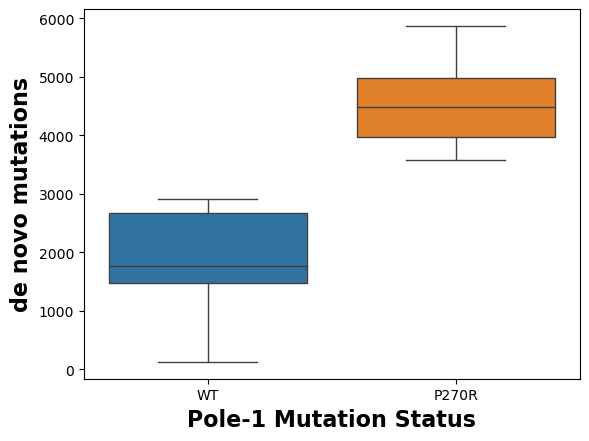

In [13]:
sns.boxplot(data=adata.obs, x='Mutation', y='private_count_per_callable_mb', hue='Mutation')
plt.xlabel("Pole-1 Mutation Status", fontweight='bold', fontsize=16)
plt.ylabel("de novo mutations", fontweight='bold', fontsize=16)

### Private mutations within each lineage

In [14]:
## Define lineage groups to look at mutation accumulation throughout the experiment
# Total count of mutations in gen 3 = Mutations unique to gen 3 + Mutations inherited from gen 2 + Mutations inherited from gen 1

def lineage_groups(row):
    if (row.name[-3] == '1') & (row.name[0] == 'P'):
        return 'P270R_P1_G1G2G3'
    if (row.name[-3] == '2') & (row.name[0] == 'P'):
        return 'P270R_P2_G1G2G3'
    if (row.name[-3] == '2') & (row.name[0] == 'N'):
        return 'WT_P2_G1G2G3'
    if (row.name[-3] == '3') & (row.name[0] == 'N'):
        return 'WT_P3_G1G2G3'
    if (row.name[-3] == '4') & (row.name[0] == 'N'):
        return 'WT_P4_G1G2G3'
    
adata.obs['mut_group_1'] = adata.obs.apply(lineage_groups, axis=1)

def second_lineage_groups(row):
    if (row.name[-3] == '1') & (row.name[0] == 'P') & (row.name[-1] in ['2','3']):
        return 'P270R_P1_G2G3'
    if (row.name[-3] == '2') & (row.name[0] == 'P') & (row.name[-1] in ['2','3']):
        return 'P270R_P2_G2G3'
    if (row.name[-3] == '2') & (row.name[0] == 'N') & (row.name[-1] in ['2','3']):
        return 'WT_P2_G2G3'
    if (row.name[-3] == '3') & (row.name[0] == 'N') & (row.name[-1] in ['2','3']):
        return 'WT_P3_G2G3'
    if (row.name[-3] == '4') & (row.name[0] == 'N') & (row.name[-1] in ['2','3']):
        return 'WT_P4_G2G3'
    else:
        return f"{row.Mutation}_{row.Replicate}_gen1"
    
adata.obs['mut_group_2'] = adata.obs.apply(second_lineage_groups, axis=1)

adata.obs

,Mutation,Replicate,Generation,mean_coverage,callable_Mb_10x,private_count,private_count_per_callable_mb,mut_group_1,mut_group_2
N2_P2G1,WT,P2,1,26.22,83.80,10462,124.844869,WT_P2_G1G2G3,WT_P2_gen1
N2_P2G2,WT,P2,2,32.60,89.57,48065,536.619404,WT_P2_G1G2G3,WT_P2_G2G3
N2_P2G3,WT,P2,3,32.74,88.27,150570,1705.789056,WT_P2_G1G2G3,WT_P2_G2G3
N2_P3G1,WT,P3,1,31.27,92.94,136320,1466.752744,WT_P3_G1G2G3,WT_P3_gen1
N2_P3G2,WT,P3,2,30.29,91.35,161056,1763.065134,WT_P3_G1G2G3,WT_P3_G2G3
N2_P3G3,WT,P3,3,26.91,87.84,179120,2039.162113,WT_P3_G1G2G3,WT_P3_G2G3
N3_P4G1,WT,P4,1,24.11,84.52,225021,2662.340274,WT_P4_G1G2G3,WT_P4_gen1
N3_P4G2,WT,P4,2,21.62,74.46,199289,2676.457158,WT_P4_G1G2G3,WT_P4_G2G3
N3_P4G3,WT,P4,3,27.58,88.34,257238,2911.908535,WT_P4_G1G2G3,WT_P4_G2G3
Pole-1_P1G1,P270R,P1,1,32.72,90.52,324426,3584.025630,P270R_P1_G1G2G3,P270R_P1_gen1


In [16]:
## Compute mutations private to lineage groups
spc.tl.private_mutations(adata,
                         groupby='mut_group_1',
                         count_strategy='genotype',
                         genotypes=[3],
                         store_key='mut_group_1'
                        )
spc.tl.private_mutations(adata,
                         groupby='mut_group_2',
                         count_strategy='genotype',
                         genotypes=[3],
                         store_key='mut_group_2'
                        )

,WT_P2_gen1,WT_P2_G2G3,WT_P3_gen1,WT_P3_G2G3,WT_P4_gen1,WT_P4_G2G3,P270R_P1_gen1,P270R_P1_G2G3,P270R_P2_gen1,P270R_P2_G2G3
I-2-C>A,False,False,False,False,False,False,False,False,False,False
I-2-C>T,False,False,False,False,False,False,False,False,False,False
I-2-C>G,False,False,False,False,False,False,False,False,False,False
I-3-C>A,False,False,False,False,False,False,False,False,False,False
I-3-C>G,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
X-17718934-A>C,False,False,False,False,False,False,False,False,False,False
X-17718936-G>T,False,False,False,False,False,False,False,False,False,False
X-17718940-A>C,False,False,False,False,False,False,False,False,False,False
X-17718940-A>G,False,False,False,False,False,False,False,False,False,False


In [17]:
## Assemble counts of accumulated mutations
## There definitely were cleaner alternatives but I was in to deep manually piecing together this df

time_series = {
    'WT_P2_G1':[adata.uns['mut_group_1_counts']['WT_P2_G1G2G3']+adata.uns['private_mutations'].sum(axis=0)['N2_P2G1'],
                1,'WT','P2'], 
    'WT_P2_G2':[adata.uns['mut_group_1_counts']['WT_P2_G1G2G3']+adata.uns['mut_group_2_counts']['WT_P2_G2G3']+adata.uns['private_mutations'].sum(axis=0)['N2_P2G1']+adata.uns['private_mutations'].sum(axis=0)['N2_P2G2'],
                2,'WT','P2'],
    'WT_P2_G3':[adata.uns['mut_group_1_counts']['WT_P2_G1G2G3']+adata.uns['mut_group_2_counts']['WT_P2_G2G3']+adata.uns['private_mutations'].sum(axis=0)['N2_P2G1']+adata.uns['private_mutations'].sum(axis=0)['N2_P2G2']+adata.uns['private_mutations'].sum(axis=0)['N2_P2G3'],
                3,'WT','P2'],
    
    'WT_P3_G1':[adata.uns['mut_group_1_counts']['WT_P3_G1G2G3']+adata.uns['private_mutations'].sum(axis=0)['N2_P3G1'],
                1,'WT','P3'], 
    'WT_P3_G2':[adata.uns['mut_group_1_counts']['WT_P3_G1G2G3']+adata.uns['mut_group_2_counts']['WT_P3_G2G3']+adata.uns['mut_group_2_counts']['WT_P2_G2G3']+adata.uns['private_mutations'].sum(axis=0)['N2_P3G1']+adata.uns['private_mutations'].sum(axis=0)['N2_P3G2'],
                2,'WT','P3'],
    'WT_P3_G3':[adata.uns['mut_group_1_counts']['WT_P3_G1G2G3']+adata.uns['mut_group_2_counts']['WT_P3_G2G3']+adata.uns['private_mutations'].sum(axis=0)['N2_P3G3']+adata.uns['private_mutations'].sum(axis=0)['N2_P3G1']+adata.uns['private_mutations'].sum(axis=0)['N2_P3G2']+adata.uns['private_mutations'].sum(axis=0)['N2_P3G3'],
                3,'WT','P3'],
    
    'WT_P4_G1':[adata.uns['mut_group_1_counts']['WT_P2_G1G2G3']+adata.uns['private_mutations'].sum(axis=0)['N3_P4G1'],
                1,'WT','P4'], 
    'WT_P4_G2':[adata.uns['mut_group_1_counts']['WT_P2_G1G2G3']+adata.uns['mut_group_2_counts']['WT_P2_G2G3']+adata.uns['private_mutations'].sum(axis=0)['N3_P4G1']+adata.uns['private_mutations'].sum(axis=0)['N3_P4G2'],
                2,'WT','P4'],
    'WT_P4_G3':[adata.uns['mut_group_1_counts']['WT_P2_G1G2G3']+adata.uns['mut_group_2_counts']['WT_P2_G2G3']+adata.uns['private_mutations'].sum(axis=0)['N3_P4G3']+adata.uns['private_mutations'].sum(axis=0)['N3_P4G1']+adata.uns['private_mutations'].sum(axis=0)['N3_P4G2'],
                3,'WT','P4'],
    
    'P270R_P1_G1':[adata.uns['mut_group_1_counts']['P270R_P1_G1G2G3']+adata.uns['private_mutations'].sum(axis=0)['Pole-1_P1G1'],
                   1,'P270R','P1'], 
    'P270R_P1_G2':[adata.uns['mut_group_1_counts']['P270R_P1_G1G2G3']+adata.uns['mut_group_2_counts']['P270R_P1_G2G3']+adata.uns['private_mutations'].sum(axis=0)['Pole-1_P1G1']+adata.uns['private_mutations'].sum(axis=0)['Pole-1_P1G2'],
                   2,'P270R','P1'],
    'P270R_P1_G3':[adata.uns['mut_group_1_counts']['P270R_P1_G1G2G3']+adata.uns['mut_group_2_counts']['P270R_P1_G2G3']+adata.uns['private_mutations'].sum(axis=0)['Pole-1_P1G3']+adata.uns['private_mutations'].sum(axis=0)['Pole-1_P1G1']+adata.uns['private_mutations'].sum(axis=0)['Pole-1_P1G2'],
                   3,'P270R','P1'],
    
    'P270R_P2_G1':[adata.uns['mut_group_1_counts']['P270R_P2_G1G2G3']+adata.uns['private_mutations'].sum(axis=0)['Pole-1_P2G1'],
                   1,'P270R','P2'], 
    'P270R_P2_G2':[adata.uns['mut_group_1_counts']['P270R_P2_G1G2G3']+adata.uns['mut_group_2_counts']['P270R_P2_G2G3']+adata.uns['private_mutations'].sum(axis=0)['Pole-1_P2G1']+adata.uns['private_mutations'].sum(axis=0)['Pole-1_P2G2'],
                   2,'P270R','P2'],
    'P270R_P2_G3':[adata.uns['mut_group_1_counts']['P270R_P2_G1G2G3']+adata.uns['mut_group_2_counts']['P270R_P2_G2G3']+adata.uns['private_mutations'].sum(axis=0)['Pole-1_P2G3']+adata.uns['private_mutations'].sum(axis=0)['Pole-1_P2G1']+adata.uns['private_mutations'].sum(axis=0)['Pole-1_P2G2'],
                   3,'P270R','P2']
}

time_series = pd.DataFrame.from_dict(data = time_series, orient='index', columns = ['Mutations', 'Generation', 'Pole-1 Mutation Status', 'Clone'])
time_series

,Mutations,Generation,Pole-1 Mutation Status,Clone
WT_P2_G1,10462,1,WT,P2
WT_P2_G2,58529,2,WT,P2
WT_P2_G3,209099,3,WT,P2
WT_P3_G1,136321,1,WT,P3
WT_P3_G2,297381,2,WT,P3
WT_P3_G3,655619,3,WT,P3
WT_P4_G1,225021,1,WT,P4
WT_P4_G2,424312,2,WT,P4
WT_P4_G3,681550,3,WT,P4
P270R_P1_G1,324438,1,P270R,P1


Text(51.342690200617284, 0.5, 'Mutations')

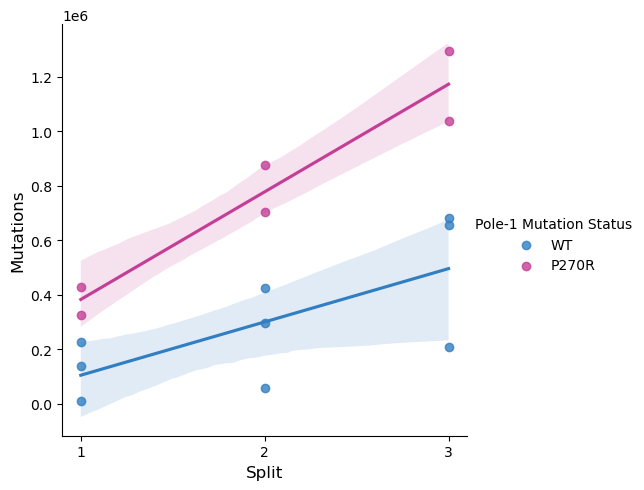

In [18]:
## Plot
g = sns.lmplot(time_series, x='Generation',y='Mutations',
           palette={'WT':'#317EC2','P270R':'#C43E96'},
           hue='Pole-1 Mutation Status'
        )

new_ticks = [1,2,3]
new_labels = ['1','2','3']
g.set(xticks=new_ticks, xticklabels=new_labels)
# plt.yscale('log')
plt.xlabel("Split", fontsize=12)
plt.ylabel("Mutations", fontsize=12)

In [19]:
g.savefig('../results/worm_mut_accumulation/mutations_vs_time.png')

In [20]:
time_series.to_csv('../results/worm_mut_accumulation/mutations.csv')

In [21]:
df = time_series
df = df.rename(columns={'Pole-1 Mutation Status': 'Genotype'})
df['CloneID'] = df['Genotype'] + '_' + df['Clone'].astype(str)
df['Genotype'] = pd.Categorical(df['Genotype'], categories=['WT', 'P270R'])

In [22]:
print("\n" + "="*70)
print("MIXED EFFECTS MODEL")
print("="*70)
print("\nModel: Mutations ~ Generation * Genotype + (Generation | CloneID)")

# Random intercept + slope model
model = smf.mixedlm(
    "Mutations ~ Generation * Genotype",
    data=df,
    groups=df["CloneID"],
    re_formula="~Generation"
)
result = model.fit(method=['lbfgs', 'powell', 'cg'])

print("\n" + str(result.summary()))


MIXED EFFECTS MODEL

Model: Mutations ~ Generation * Genotype + (Generation | CloneID)

                          Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          Mutations      
No. Observations:            15               Method:                      REML           
No. Groups:                  5                Scale:                       1660011195.8292
Min. group size:             3                Log-Likelihood:              -142.0076      
Max. group size:             3                Converged:                   Yes            
Mean group size:             3.0                                                          
------------------------------------------------------------------------------------------
                                 Coef.       Std.Err.    z    P>|z|    [0.025     0.975]  
------------------------------------------------------------------------------------------
Intercept                   

In [23]:
# Extract key coefficients
print("\n" + "-"*70)
print("KEY COEFFICIENTS:")
print("-"*70)
print(f"WT baseline rate (Generation):           {result.fe_params['Generation']:,.0f} mutations/split")
print(f"P270R additional rate (Gen:Genotype):    {result.fe_params['Generation:Genotype[T.P270R]']:,.0f} mutations/split")
print(f"P270R total rate:                        {result.fe_params['Generation'] + result.fe_params['Generation:Genotype[T.P270R]']:,.0f} mutations/split")
print(f"\nInteraction p-value: {result.pvalues['Generation:Genotype[T.P270R]']:.2e}")



----------------------------------------------------------------------
KEY COEFFICIENTS:
----------------------------------------------------------------------
WT baseline rate (Generation):           195,744 mutations/split
P270R additional rate (Gen:Genotype):    199,561 mutations/split
P270R total rate:                        395,305 mutations/split

Interaction p-value: 4.53e-03


In [24]:
print("\n" + "="*70)
print("PER-CLONE REGRESSION LINES")
print("="*70)

clone_stats = []
for clone in df['CloneID'].unique():
    clone_data = df[df['CloneID'] == clone].sort_values('Generation')
    genotype = clone_data['Genotype'].iloc[0]
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        clone_data['Generation'],
        clone_data['Mutations']
    )
    
    clone_stats.append({
        'CloneID': clone,
        'Genotype': genotype,
        'Slope': slope,
        'Intercept': intercept,
        'R_squared': r_value**2,
        'Slope_SE': std_err
    })

clone_df = pd.DataFrame(clone_stats)
print("\n", clone_df.to_string(index=False))

# Summary by genotype
print("\n" + "-"*70)
print("SUMMARY BY GENOTYPE:")
print("-"*70)

for geno in ['WT', 'P270R']:
    subset = clone_df[clone_df['Genotype'] == geno]
    print(f"\n{geno}:")
    print(f"  Slope (mean ± SD):     {subset['Slope'].mean():>10,.0f} ± {subset['Slope'].std():,.0f}")
    print(f"  Intercept (mean ± SD): {subset['Intercept'].mean():>10,.0f} ± {subset['Intercept'].std():,.0f}")

# Fold change
wt_rate = clone_df[clone_df['Genotype'] == 'WT']['Slope'].mean()
p270r_rate = clone_df[clone_df['Genotype'] == 'P270R']['Slope'].mean()
print(f"\nFold change (P270R / WT): {p270r_rate / wt_rate:.2f}x")



PER-CLONE REGRESSION LINES

  CloneID Genotype    Slope      Intercept  R_squared     Slope_SE
   WT_P2       WT  99318.5 -105940.333333   0.918474 29590.067321
   WT_P3       WT 259649.0 -156191.000000   0.954146 56920.385689
   WT_P4       WT 228264.5  -12901.333333   0.994658 16727.858024
P270R_P1    P270R 357033.0  -25599.333333   0.998850 12116.850099
P270R_P2    P270R 433577.5    -391.666667   0.999541  9293.895958

----------------------------------------------------------------------
SUMMARY BY GENOTYPE:
----------------------------------------------------------------------

WT:
  Slope (mean ± SD):        195,744 ± 84,969
  Intercept (mean ± SD):    -91,678 ± 72,702

P270R:
  Slope (mean ± SD):        395,305 ± 54,125
  Intercept (mean ± SD):    -12,995 ± 17,825

Fold change (P270R / WT): 2.02x


In [25]:
print("\n" + "="*70)
print("STATISTICAL TESTS ON SLOPES")
print("="*70)

wt_slopes = clone_df[clone_df['Genotype'] == 'WT']['Slope']
p270r_slopes = clone_df[clone_df['Genotype'] == 'P270R']['Slope']

# Welch's t-test
t_stat, p_ttest = stats.ttest_ind(p270r_slopes, wt_slopes, equal_var=False)
print(f"\nWelch's t-test: t = {t_stat:.3f}, p = {p_ttest:.4f}")


STATISTICAL TESTS ON SLOPES

Welch's t-test: t = 3.207, p = 0.0497


# Mutation Spectrum

Computing spectrum (key='spectrum'): 100%|██████████| 15/15 [01:05<00:00,  4.35s/cell]


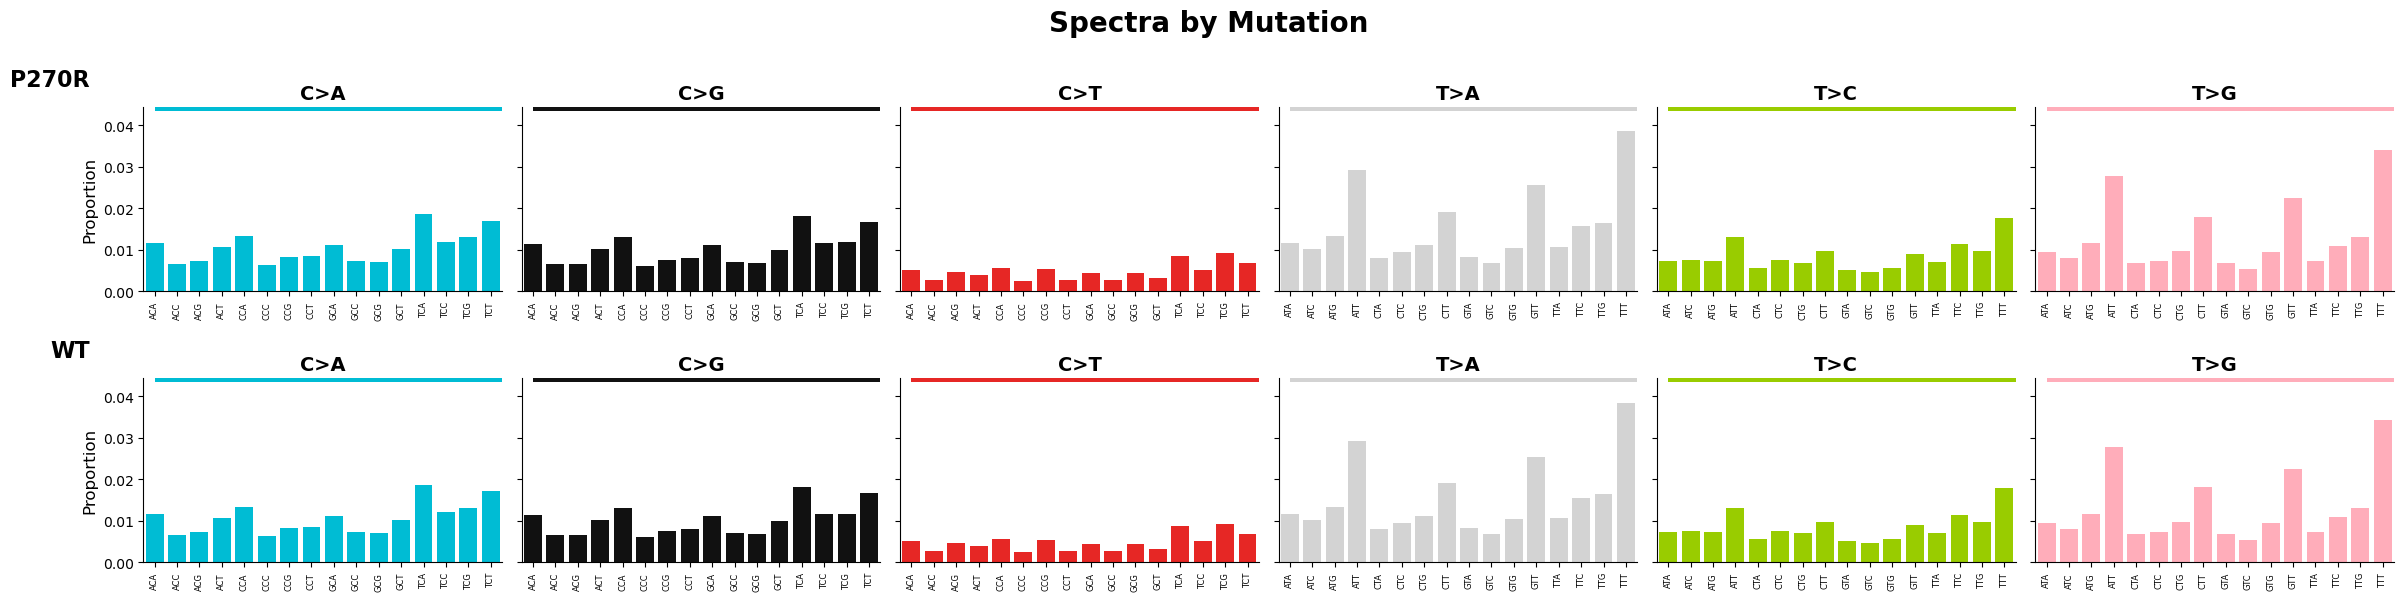

In [26]:
spc.tl.compute_spectrum(adata)
spc.pl.spectrum(adata,
                groupby='Mutation',
                title='',
                normalize=True
               )

# Save results

In [28]:
adata.write_h5ad('../results/worm_mut_accumulation/bulk_worm_processed.h5ad')

IORegistryError: No method registered for writing <class 'pandas.core.series.Series'> into <class 'h5py._hl.group.Group'>